# Graph Scoped DAO
A proof of concept graph network that provides implicit scope through the structure of its votable interactions.  All actions of the DAO are modelled as actor/resrouce actions.  The set of actions is used to build and visualize the DAO.  Continuous staking on actions causes stateful updates of resources controlled by the DAO via the actor/resource actions.  

**Benefits:**
- Formal analysis of actors, resources possible.
- Participant values can be added in multiple places and modelled - choosing what edges exist as well as how the actions are activated.
- The graph has explicit scope and that scope can be visualized.  Artist rendering of how the system is controlled can be made 'to scale'.
- Scalable and dockable.  Very complex governance can be modelled and added in pieces with open verification of interacting elements and modelling of the system available at every change.  A huge improvement over subjective law.

**Cons:**
- Everything is explicit. Implicit governance can only be done through vague actions.
- Fluidity and timing of state updates is another layer of complexity.  May need a structure to control state updates. 
- Disaster recovery must be modelled in.
- Even a simple graph or simple vote activation function may lead to complex, unwanted, behaviors unseen before.

## The Action

A class of actor, resource(s), and functions with side effects on those resource(s).  A resource can be an actor itself for more complicated graphs.

In [1]:
from pydantic import BaseModel
from typing import List, Dict, Any


class Resource(BaseModel):
    identifier: str

    def __repr__(self):
        return self.identifier
    
        
class Actor(Resource):
    identifier: str
        
    def __repr__(self):
        return self.identifier


class Contract(BaseModel):
    identifier: str
    kwargs: Dict[str, Resource]
    fn: Any
    
    def execute(self):
        try:
            self.fn(self.kwargs)
        except Exception as e:
            print('Error: could not execute contract')
            raise e
    

class Action(BaseModel):
    identifier: str
    actor: Actor
    resources: List[Resource]
    contract: Contract
        
    @property
    def nodes(self) -> list:
        n = []
        n.extend([r.identifier for r in self.resources])
        n.extend([self.actor.identifier])
        return n
    
    @property
    def edges(self) -> list:
        e = []
        e.extend([(self.actor.identifier, r.identifier, {'contract':self.contract}) for r in self.resources])
        return e

In [2]:
# A resource can be scarce or restricted object (this can be a wallet, login service, payment authorization token api, whatever)
wallet = Resource(identifier='00x1')

# An actor should be required by the contract function, otherwise the edge is meaningless.
me = Actor(identifier='JD')

# A contract is any function of named arguments.  
#  This can certainly be a smart contract, but side effects don't have to be on chain.
contract = Contract(
    identifier = 'simple_print',
    kwargs = {'owner': me, 'wallet': wallet}, 
    fn = lambda kw: print(f"{kw['owner'].identifier} owns {kw['wallet'].identifier}"
))

# The Action is an edge of the network.  We define actions and build the network from concrete actions
#  opposed 
print_info = Action(
    identifier='p1',
    actor=me, 
    resources=[wallet], 
    contract=contract)

print_info.contract.execute()  # In practice, executed by stake net

JD owns 00x1


# The Graph
By registering actions, a graph can be built.

In [3]:
import networkx as nx

class DGraph():
    def __init__(self):
        self.__g = nx.Graph()
        
    def register_action(self, action: Action):
        self.__g.add_nodes_from(action.nodes)
        self.__g.add_edges_from(action.edges)
        print(f"added {action.nodes}, {action.edges}")
        
    @property
    def num_nodes(self):
        return self.__g.number_of_nodes()
    
    @property
    def num_edges(self):
        return self.__g.number_of_edges()
    
    @property
    def nodes(self):
        return self.__g.nodes
    
    @property
    def edges(self):
        return self.__g.edges
    
    def get_edge(self, a, b):
        return self.__g[a][b]
    
    def draw(self, *args, **kwargs):
        nx.draw(self.__g, *args, **kwargs)

In [4]:
# Register actions to build the graph
dg = DGraph()
dg.register_action(print_info)

added ['00x1', 'JD'], [('JD', '00x1', {'contract': Contract(identifier='simple_print', kwargs={'owner': JD, 'wallet': 00x1}, fn=<function <lambda> at 0x7fa112d27430>)})]


In [5]:
dg.num_nodes, dg.num_edges

(2, 1)

In [6]:
dg.nodes

NodeView(('00x1', 'JD'))

In [7]:
dg.edges

EdgeView([('00x1', 'JD')])

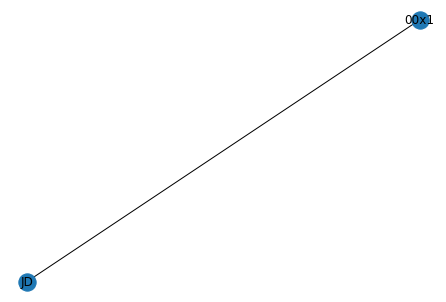

In [8]:
# Visualize the graph (it's very simple now)
dg.draw(with_labels=True)

# The Neural Component
Integrating stake is a modular fashion can be done in many different ways.  Here, I model it based on a vector of votes on actions.  The main thing is to note that many interpretations of voting pattern are easier to exploit when you have an explicit vector of rational quantities tied to known, validated, actions.

## A More complex graph
Let's emulate a more complex graph, for example an election.

added ['Mary', 'elector'], [('elector', 'Mary', {'contract': Contract(identifier='elector_Mary', kwargs={'elector': elector, 'candidate': Mary}, fn=<function elect at 0x7fa0f2b435e0>)})]
added ['John', 'elector'], [('elector', 'John', {'contract': Contract(identifier='elector_John', kwargs={'elector': elector, 'candidate': John}, fn=<function elect at 0x7fa0f2b435e0>)})]
added ['Tsu', 'elector'], [('elector', 'Tsu', {'contract': Contract(identifier='elector_Tsu', kwargs={'elector': elector, 'candidate': Tsu}, fn=<function elect at 0x7fa0f2b435e0>)})]
added ['Ali', 'elector'], [('elector', 'Ali', {'contract': Contract(identifier='elector_Ali', kwargs={'elector': elector, 'candidate': Ali}, fn=<function elect at 0x7fa0f2b435e0>)})]


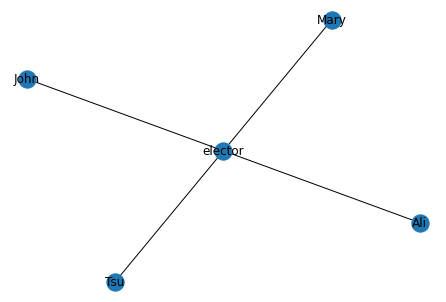

In [9]:
# Elector <- The actor that will actually select the winner whatever that means

elector = Actor(identifier='elector')

# Candidates
candidates = [
    Actor(identifier='Mary'),   # Remember an actor is a resource. Using 'Actor' here for semantic comfort
    Actor(identifier='John'),
    Actor(identifier='Tsu'),
    Actor(identifier='Ali'),
]

# Function & Contracts
def elect(kwargs):
    print(f"{kwargs['elector']} has chosen {kwargs['candidate']} as the winner!")
    
contracts = []
for candidate in candidates:
    contracts.append(
        Contract(
            identifier=f"elector_{candidate.identifier}",
            kwargs={'elector': elector, 'candidate': candidate},
            fn = elect
        )
    )
    
# Actions
actions = []
for candidate, contract in zip(candidates, contracts):
    actions.append(
            Action(
            identifier=candidate.identifier,
            actor=elector,
            resources=[candidate], 
            contract=contract
        )
    )
    

# Build the graph
dg = DGraph()
for action in actions:
    dg.register_action(action)
    
# Visualize the graph
dg.draw(with_labels=True)

## Build The Voting Vector
Create a voting vector tied to each edge.  

In [10]:
class VoteRecord():
    def __init__(self):
        self.__record = {}
        self.__index = None
    
    @property
    def record(self):
        return self.__record
    
    @property
    def index(self):
        if self.__index is None:
            self.__index = {}
            for i, val in enumerate(self.__record.keys()):
                self.__index[i] = val
        return self.__index
    
    def build_from_graph(self, graph: DGraph):
        for nt in graph.edges:
            edge = graph.get_edge(*nt)  # I am starting to abuse/drift/make ugly the networkX API here. sorry
            self.__record[edge['contract'].identifier] = 0
            
    def vote(self, idx):
        contract = self.__index[idx]
        self.__record[contract] += 1
            
    

In [11]:
vr = VoteRecord()
vr.build_from_graph(graph=dg)

In [12]:
vr.record, vr.index

({'elector_Mary': 0, 'elector_John': 0, 'elector_Tsu': 0, 'elector_Ali': 0},
 {0: 'elector_Mary', 1: 'elector_John', 2: 'elector_Tsu', 3: 'elector_Ali'})

In [13]:
## Let's do some random voting
import random

for _ in range(1000):
    vr.vote(random.randint(0, len(vr.index)-1))

vr.record

{'elector_Mary': 274,
 'elector_John': 252,
 'elector_Tsu': 244,
 'elector_Ali': 230}

## Activations
Now we can decide which edges to activate.  This logic can be as simple or complex as required.

In [14]:
# Ultimate Voting Decision Making Ultimate Function of Ultimate
def choose_winner(vr: VoteRecord):
    sorted_votes = sorted(vr.record.items(), key=lambda x: -x[1])
    winner = sorted_votes[0]
    return winner[0]

In [15]:
winner = choose_winner(vr)
winner

'elector_Mary'

In [16]:
# Activate the winner!
dg.get_edge(*winner.split('_'))['contract'].execute()

identifier='elector' has chosen identifier='Mary' as the winner!
